# Random Forest Model For Predicting First Day IPO Performance

This notebook trains and tests a random forest model to predict whether an IPO (Inital Public Offering) will be underpriced or not.

To begin, we will import the necessary modules and libraries

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import pickle
# visualizaitions
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

import itertools
import os
import numpy as np
import matplotlib.pyplot as plt


We first read the ipo data from a csv to a pandas data frame.

After collecting the labels for the data points, we select all numeric features so that it can be processed in the random forest model. We store the labels of the features we choose to use in `ipo_features`.



In [2]:
# load dataset
ipos = pd.read_csv("../data/clean_bloomberg_with_sectors_macro.csv")
# get labels
ipo_labels = ipos["Underpriced"].tolist()
# get features
ipos = ipos.select_dtypes(['float64', 'float32', int])
ipo_features = ipos._get_numeric_data().columns.values.tolist()[1:-1]
# remove feature wich defines the label
ipo_features.remove('Offer To 1st Close')
# TODO remove these features from the csv
ipo_features.remove('Shares Outstanding (M).1')
ipo_features.remove('Offer Size (M).1')
print("Possible Features:", ipo_features)

Possible Features: ['Profit Margin', 'Return on Assets', 'Offer Size (M)', 'Shares Outstanding (M)', 'Offer Price', 'Market Cap at Offer (M)', 'Cash Flow per Share', 'Instit Owner (% Shares Out)', 'Instit Owner (Shares Held)', 'Real GDP Per Capita', 'OECD Leading Indicator', 'Interest Rate', 'Seasonally Adjusted Unemployment Rate', 'CPI Growth Rate', 'Industry Sector', 'Industry Group', 'Industry Subgroup']


The features we have chose to use are stored in `ipo_features_data` as a pandas dataframe. Using this data frame long with the labels, we make a test and training split. 

We then use `sci-kit learn`'s Random Forest model to initialize a classification model. This model is trained on the designated training data we have created. We then make a prediction by feeding the newly created model the test set we created.

Random forest is an ensemble machine learning algorithm that uses multiple decision trees to make predictions. It works by randomly selecting a subset of features from the dataset and then building a decision tree for each subset. This is process is called bagging. Each tree is then used to make a prediction, and the final prediction is made by taking the average of all the individual tree predictions. Bagging along with with the other processes helps reduce overfitting and improves accuracy. Random forest also has the ability to handle large datasets with high dimensionality, making it a powerful tool for predictive analytics.

In [3]:
# get columns for specified features
ipo_features = ipo_features[:-1]
ipo_features_data = ipos[ipo_features]
# split dataset to trianing set and test set
ipo_features_data_train, ipo_features_data_test, ipo_labels_train, ipo_labels_test = train_test_split(ipo_features_data, ipo_labels, test_size=0.3)
# create classifier 
clf = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                             criterion="entropy", max_depth=13, max_features="auto", 
                             max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0,
                             min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, 
                             n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0,
                             warm_start=False)
"""
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 
'max_depth': 13, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 
'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 
'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
"""
# train the model
clf.fit(ipo_features_data_train, ipo_labels_train)
# predict
ipo_labels_pred = clf.predict(ipo_features_data_test)
accuracy = metrics.accuracy_score(ipo_labels_test, ipo_labels_pred)
print("Accuracy:", accuracy)

0.707843137254902

## Finding Best Random Forest Configuraiton
To find the best configuration for training a random forest model, we analyze four important parameters :
* _estimators_ - The number of trees in the forest 
* _criterion_ -  The function to measure the quality of a split
* _max_depth_ - The maximum allowed depth for trees
* _bootstrap_ - Whether the model will using bootstrapping

We compute the permutation of all of these parameters, and train a model for each one. To ensure model training consistency, all the models are trained on the same test and training data set. This reduces the possible descrepency that could result from having a variation on data samples. The models are saved for later analysis. 

In [ ]:
# define the traning data and test data
ipo_features_data_train, ipo_features_data_test, ipo_labels_train, ipo_labels_test = train_test_split(ipo_features_data, ipo_labels, test_size=0.3)

The code segment below can be ran to save train and then save a model for every permutaiton of the specified model parameters. 

In [17]:
# create random forest models with various parameters
def create_model(name, n_estimators, criterion, max_depth, bootstrap) :
    model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, bootstrap=bootstrap)
    model.fit(ipo_features_data_train, ipo_labels_train)
    with open('saved_models/random_forest/' + name + ".pkl", 'wb') as file :
        pickle.dump(model, file)

# possible parameters
estimators = [x for x in range(100, 900, 100)]
criterion = ["gini", "entropy"]
max_depth = [x for x in range(6, len(ipo_features))]
bootstrap = [True, False]
params = [estimators, criterion, max_depth, bootstrap]

# trains and saves random forest models with a permutation of the given parameters
def compute_all_models(params) :
    name = "random_forest_"
    s = list(itertools.product(*params))
    for i in range(len(s)) :
        n_estimators, criterion, max_depth, bootstrap = s[i]
        create_model(name + str(i), n_estimators, criterion, max_depth, bootstrap)


For every saved model, we evaluate its accuracy and keep track of the best and worst performing model. We save the information about all the models in a `pandas` dataframe for further analaysis.

In [17]:
def eval_model(model) :
    ipo_labels_pred = model.predict(ipo_features_data_test)
    accuracy = metrics.accuracy_score(ipo_labels_test, ipo_labels_pred)
    return accuracy

# init data frame
model_accuracies_df = pd.DataFrame(columns=["Model Name", "Accuracy", "Parameters"])

# best model 
best_accuracy = -1.0
best_model_name = ""
best_model_params = {}
# worst model 
worst_accuracy = 1.1
worst_model_name = ""
worst_model_params = {}

# for every model, evaluate it, and store it in a pandas data frame
dir_path = "saved_models/random_forest"
idx = 0
for file in os.listdir(dir_path):
    # load model and get name
    with open(os.path.join(dir_path, file), "rb") as f:
        model = pickle.load(f)
        model_name = os.path.splitext(file)[0]
    # evaulate accuracy, get params
    model_accuracy = eval_model(model)
    model_params = model.get_params(True)
    # write to df
    model_accuracies_df.loc[idx] = {
        "Model Name": model_name,
        "Accuracy": model_accuracy,
        "Parameters": model_params
    }
    # keep track of best and worst accuracy
    if best_accuracy < model_accuracy :
        best_accuracy = model_accuracy
        best_model_name = model_name
        best_model_params = model_params
    elif worst_accuracy > model_accuracy :
        worst_accuracy = model_accuracy
        worst_model_name = model_name
        worst_model_params = model_params
    # increment row count
    idx += 1

Having all the saved model data, we clean up the dataframe.

In [18]:
# convert parameters cols to cols in the data frame
model_accuracies_df = model_accuracies_df.join(model_accuracies_df["Parameters"].apply(pd.Series))
# drop the intermediary "Parameters" col
model_accuracies_df = model_accuracies_df.drop(columns=["Parameters"])
model_accuracies_df

,Model Name,Accuracy,bootstrap,ccp_alpha,class_weight,criterion,max_depth,max_features,max_leaf_nodes,max_samples,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,n_jobs,oob_score,random_state,verbose,warm_start
0,random_forest_977,0.878431,False,0.0,None,gini,9,auto,None,None,0.0,1,2,0.0,900,None,False,None,0,False
1,random_forest_963,0.705882,False,0.0,None,gini,2,auto,None,None,0.0,1,2,0.0,900,None,False,None,0,False
2,random_forest_793,0.817647,False,0.0,None,gini,7,auto,None,None,0.0,1,2,0.0,750,None,False,None,0,False
3,random_forest_787,0.721569,False,0.0,None,gini,4,auto,None,None,0.0,1,2,0.0,750,None,False,None,0,False
4,random_forest_778,0.917647,True,0.0,None,entropy,15,auto,None,None,0.0,1,2,0.0,700,None,False,None,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,random_forest_991,0.705882,False,0.0,None,entropy,1,auto,None,None,0.0,1,2,0.0,900,None,False,None,0,False
1076,random_forest_761,0.776471,False,0.0,None,entropy,6,auto,None,None,0.0,1,2,0.0,700,None,False,None,0,False
1077,random_forest_775,0.917647,False,0.0,None,entropy,13,auto,None,None,0.0,1,2,0.0,700,None,False,None,0,False
1078,random_forest_946,0.841176,True,0.0,None,entropy,9,auto,None,None,0.0,1,2,0.0,850,None,False,None,0,False


In [10]:
# write the results to a csv
model_accuracies_df.to_csv("../data/model_data/random_forest_model_results.csv")

In [19]:
# select the one witht he best accuracy 
print("Model " + best_model_name + " had the best accuracy with a score of", best_accuracy )
print("Best model params:", best_model_params)
print()
print("Model " + worst_model_name + " had the worst accuracy with a score of", worst_accuracy)
print("Worst model params: ", worst_model_params)

Model random_forest_146 had the best accuracy with a score of 0.9254901960784314
Best model params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 14, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Model random_forest_963 had the worst accuracy with a score of 0.7058823529411765
Worst model params:  {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 900, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


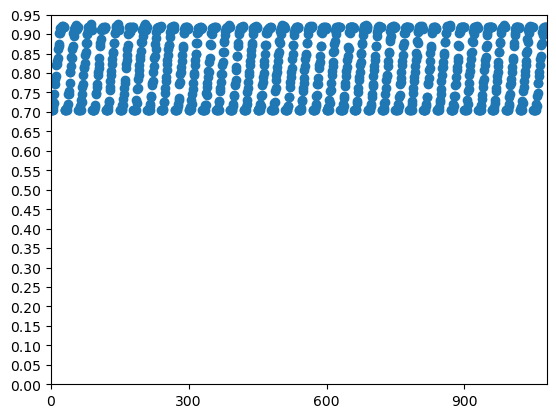

In [20]:
model_nums = list(map(lambda x: int(x[14:]), model_accuracies_df["Model Name"].values)) # truncate the name of the model
values = model_accuracies_df["Accuracy"].values
fig, ax = plt.subplots()
ax.scatter(model_nums, values)
ax.set(ylim=(0.0, 0.1), yticks=np.arange(0, 1, 0.05), xlim=(0, 1079), xticks=np.arange(0, 1079, 300))
plt.show()

We now analyze the importance of each feature.

In [16]:
# find feature importance
best_model_path = "saved_models/random_forest/" + best_model_name + ".pkl"

with open(best_model_path, "rb") as f:
    best_model = pickle.load(f)

best_feature_imp = pd.Series(best_model.feature_importances_,index=[ipo_features]).sort_values(ascending=False)
print("best model feature importance:\n", best_feature_imp)

print()
worst_model_path = "saved_models/random_forest/" + worst_model_name + ".pkl"
with open(worst_model_path, "rb") as f:
    worst_model = pickle.load(f)

worst_feature_imp = pd.Series(worst_model.feature_importances_,index=[ipo_features]).sort_values(ascending=False)
print("worst model feature importance:\n", worst_feature_imp)

best model feature importance:
 Profit Margin                            0.082747
Market Cap at Offer (M)                  0.078792
Cash Flow per Share                      0.078030
Return on Assets                         0.077670
Offer Size (M)                           0.073957
Instit Owner (Shares Held)               0.072898
Instit Owner (% Shares Out)              0.072589
Shares Outstanding (M)                   0.071885
CPI Growth Rate                          0.063422
Industry Group                           0.059095
Offer Price                              0.057029
Seasonally Adjusted Unemployment Rate    0.056256
OECD Leading Indicator                   0.054914
Real GDP Per Capita                      0.048190
Interest Rate                            0.029225
Industry Sector                          0.023299
dtype: float64

worst model feature importance:
 Market Cap at Offer (M)                  0.239955
Offer Price                              0.130528
Instit Owner (% Sha

In [17]:
ipo_labels_pred = clf.predict(ipo_features_data_test)
accuracy = metrics.accuracy_score(ipo_labels_test, ipo_labels_pred)
accuracy

0.7490196078431373

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [ ]:
estimator = clf.estimators_[10]

In [ ]:
export_graphviz(estimator, out_file='small_tree.dot', 
                feature_names = ['Offer Price', 'Opening Price'],
                #class_names = clf.target_names,
                rounded = True, proportion = False, 
                precision = 1, filled = True)

In [ ]:
call(['dot', '-Tpng', 'small_tree.dot', '-o', 'small_tree.png', '-Gdpi=600'])

In [ ]:
Image(filename = 'small_tree.png')